In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
from pyro import distributions as dst
from collections import defaultdict
import matplotlib.pylab as plt

In [2]:
pyro.enable_validation(True)

In [3]:
N = 10000
D = 10

In [8]:
def dgp(X):
#def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K = 7
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [9]:
trace = pyro.poutine.trace(dgp).get_trace(torch.zeros(N,D))
logp = trace.log_prob_sum()
true_variables = [trace.nodes[name]["value"] for name in trace.stochastic_nodes]
trace.stochastic_nodes

['D', 'loc', 'scale', 'K', 'cov_factor', 'N', 'obs']

In [10]:
logp

tensor(-273011.6875)

In [11]:
_,true_loc,true_scale,_,true_cov_factor,_,data = true_variables

In [12]:
K = 7
#initial_hyperparameters = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D)*10)
initial_hyperparameters = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)

In [13]:
#def model(X):
def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [14]:
def guide(X, hyperparameters):
#def guide(X):
    #K = 2
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D, dim=-1):
        # get initial parameter values from parent
        # define parameters, clone initial parameter values from supplied hyperparameters, to avoid updating them
        loc_loc = pyro.param('loc_loc', locloc)
        loc_scale = pyro.param('loc_scale', locscale, constraint=constraints.positive)
        cov_diag_loc = pyro.param('scale_loc', scaleloc)
        cov_diag_scale = pyro.param('scale_scale', scalescale, constraint=constraints.positive)
        # sample variables
        loc = pyro.sample('loc', dst.Normal(loc_loc,loc_scale))
        with pyro.plate('K', K, dim=-2):
            cov_factor_loc = pyro.param('cov_factor_loc_{}'.format(K), cov_factor_loc)
            cov_factor_scale = pyro.param('cov_factor_scale_{}'.format(K), cov_factor_scale, constraint=constraints.positive)
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc, cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
        cov_diag = pyro.sample('scale', dst.LogNormal(cov_diag_loc, cov_diag_scale))
    return loc, cov_factor, cov_diag

In [15]:
track_params = True
def per_param_callable(module_name, param_name):
    #return {"lr": 0.01, "betas": (0.9, 0.8)} # too much momentum slows down learning apparently
    #return {"lr": 0.005, "betas": (0.9, 0.9)} # too much momentum slows down learning apparently
    return {"lr": 0.01, "betas": (0.90, 0.999)} # from http://pyro.ai/examples/svi_part_i.html
    #return {"lr": 0.001, 'betas': [0.9, 0.99]}
    #return {"lr": 0.01, 'betas': [0.9, 0.99]}
    #return {"lr": 0.1, 'betas': [0.9, 0.99]}

In [16]:
pyro.clear_param_store()

In [17]:
conditioned_model = pyro.condition(model, data = {'obs': data})
optim = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': per_param_callable, 'gamma': 0.99 })
elbo = Trace_ELBO()
svi = SVI(conditioned_model, guide, scheduler, loss=elbo, num_samples=50)

In [18]:
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
# take one svi step to populate the param store
loss = svi.step(data, initial_hyperparameters)
#loss = svi.step(data, initial_hyperparameters)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [19]:
# if the dgp is contained within the model:
# check that the loss is small on true parameters, i.e. parameters where means are the true variables, and scales are 0.01

#params = pyro.get_param_store()
#scales = 0.0001
#true_params = (true_loc,scales*torch.ones_like(params.get_param('loc_scale')),\
#               true_scale,scales*torch.ones_like(params.get_param('scale_scale')),\
#              true_cov_factor,scales*torch.ones_like(params.get_param('cov_factor_scale_1')))
#for name,new_value in zip(params.get_all_param_names(),true_params):
#    params.replace_param(name,new_value,params.get_param(name))
#    
#print(true_params)
#print(svi.loss(conditioned_model, guide, data))

In [20]:
# check that the loss is big on random parameters
params = pyro.get_param_store()
true_params = (torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D)))
for name,new_value in zip(params.get_all_param_names(),true_params):
    params.replace_param(name,new_value,params.get_param(name))

print(true_params)
print(svi.loss(conditioned_model, guide, data, initial_hyperparameters))
# check loss on initial parameters
params = pyro.get_param_store()
true_params = (torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D)*10)
for name,new_value in zip(params.get_all_param_names(),true_params):
    params.replace_param(name,new_value,params.get_param(name))
    
print(true_params)
print(svi.loss(conditioned_model, guide, data, initial_hyperparameters))

(tensor([-0.3609, -0.7757,  0.4776, -1.0295,  0.2660, -0.8785,  0.8363,  0.7798,
         0.3519, -0.5511], requires_grad=True), tensor([0.9682, 0.5347, 1.4588, 2.0323, 0.3174, 0.4395, 0.5255, 0.2291, 1.5186,
        0.2729]), tensor([ 0.1724,  1.2123,  0.4066, -1.8226,  0.7395,  1.3562,  1.2795,  0.0433,
         1.6884, -0.2415], requires_grad=True), tensor([0.5252, 1.7339, 0.1648, 0.7263, 0.1774, 0.3590, 0.1839, 0.9646, 0.8033,
        0.4936]), tensor([[-0.8236,  0.5651,  0.2864,  0.7222, -0.6818, -1.6139, -0.6428,  0.1236,
          0.2709, -0.5351],
        [-0.1356,  0.0725, -1.3139,  0.5881,  0.6899, -2.2615, -2.6875, -0.7188,
         -1.1365, -0.7799],
        [ 0.7980, -0.4527,  0.4495, -0.0977,  0.9820,  0.3992,  0.5691, -0.2963,
         -0.6104,  0.7117],
        [ 0.9794,  0.1687,  0.8240, -0.1841, -0.8039,  0.1876, -0.5731,  0.6220,
          0.8813,  1.1098],
        [-0.1742,  0.7310,  0.6133,  0.9636,  1.4417, -0.3994, -0.1637,  0.2534,
         -1.2495, -0.5891],
  

In [21]:
# optimize
for i in range(20000):
    loss = svi.step(data, initial_hyperparameters)
    if i % 100:
        print('.', end='')
    else:
        scheduler.step()
        state = scheduler.get_state()['loc_loc']
        print('\nSetting lr to {}'.format(state['base_lrs'][0]*state['gamma']**state['last_epoch']), end='')
        print('\n', end='')
    #loss = svi.step(data, initial_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        #print('.' if i % 100 else '\n', end='')
params = pyro.get_param_store()


Setting lr to 0.0099
...................................................................................................
Setting lr to 0.009801
...................................................................................................
Setting lr to 0.00970299
...................................................................................................
Setting lr to 0.0096059601
...................................................................................................
Setting lr to 0.009509900499
...................................................................................................
Setting lr to 0.00941480149401
...................................................................................................
Setting lr to 0.0093206534790699
...................................................................................................
Setting lr to 0.0092274469442792
.............................................................................

...................................................................................................
Setting lr to 0.005309055429551132
...................................................................................................
Setting lr to 0.00525596487525562
...................................................................................................
Setting lr to 0.005203405226503064
...................................................................................................
Setting lr to 0.005151371174238033
...................................................................................................
Setting lr to 0.005099857462495653
...................................................................................................
Setting lr to 0.005048858887870696
...................................................................................................
Setting lr to 0.004998370298991989
........................................................

...................................................................................................
Setting lr to 0.002904884943099638
...................................................................................................
Setting lr to 0.002875836093668641
...................................................................................................
Setting lr to 0.0028470777327319545
...................................................................................................
Setting lr to 0.002818606955404635
...................................................................................................
Setting lr to 0.0027904208858505887
...................................................................................................
Setting lr to 0.002762516676992083
...................................................................................................
Setting lr to 0.0027348915102221624
....................................................

...................................................................................................
Setting lr to 0.001589427091997875
...................................................................................................
Setting lr to 0.0015735328210778963
...................................................................................................
Setting lr to 0.0015577974928671174
...................................................................................................
Setting lr to 0.001542219517938446
...................................................................................................
Setting lr to 0.0015267973227590618
...................................................................................................
Setting lr to 0.001511529349531471
...................................................................................................
Setting lr to 0.0014964140560361563
...................................................

In [22]:
list(pyro.get_param_store().items())

[('loc_loc',
  tensor([ 0.1191,  0.1634, -2.2423,  0.0425, -2.2601, -3.0545, -0.7985, -0.0735,
          -2.2883, -0.3673], requires_grad=True)),
 ('loc_scale',
  tensor([0.0574, 0.0141, 0.0252, 0.0167, 0.0220, 0.0209, 0.0193, 0.0192, 0.0308,
          0.0316], grad_fn=<AddBackward0>)),
 ('scale_loc',
  tensor([ 3.7964,  0.3236,  1.7112, -0.9196,  1.2161,  0.0214, -3.5788,  0.7826,
          -0.8534, -0.8652], requires_grad=True)),
 ('scale_scale',
  tensor([0.0150, 0.0206, 0.0173, 0.0893, 0.0204, 0.1320, 0.5830, 0.0246, 0.1934,
          0.2512], grad_fn=<AddBackward0>)),
 ('cov_factor_loc_7',
  tensor([[ 2.0780,  0.9615, -0.3419, -0.9802, -3.5547, -0.5591,  3.6864,  1.0469,
           -3.2086, -0.8980],
          [-0.7864,  0.3534, -0.0224,  0.3690,  1.7110, -0.7674, -0.0742,  1.3336,
            4.3043,  0.7192],
          [-1.0279,  0.4585,  2.0636, -0.4088,  0.8507,  4.0279,  1.1963,  2.9683,
           -1.9820,  3.1237],
          [ 1.5693,  2.6537, -0.9402,  0.1051, -2.7717, -5.

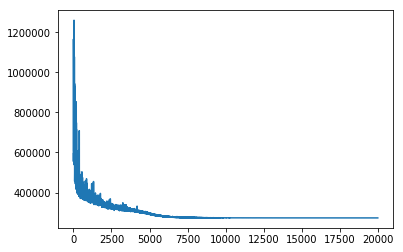

In [23]:
plt.plot(losses)

In [24]:
gradient_norms.keys()

dict_keys(['cov_factor_loc_7', 'scale_loc', 'loc_loc'])

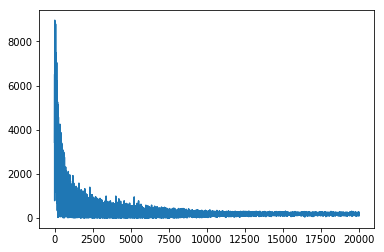

In [25]:
plt.plot(gradient_norms['loc_loc'])

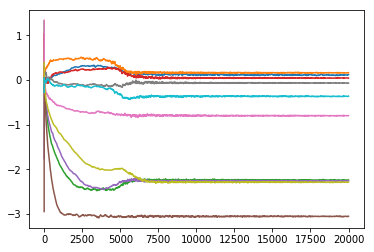

In [26]:
plt.plot(param_history['loc_loc'].detach().numpy())

In [27]:
plt.plot(param_history['cov_factor_loc_1'].reshape(-1,K*D).detach().numpy())

KeyError: 'cov_factor_loc_1'

In [28]:
# MAP
est_cov_factor = pyro.param('cov_factor_loc_{}'.format(K))
est_diag = dst.LogNormal(params.get_param('scale_loc'),params.get_param('scale_scale')).mean

In [31]:
# EXPECTED COVARIANCE AND CORRELATION
#true_total_cov = true_cov_factor.transpose(0,1) @ true_cov_factor + torch.diag(true_scale)
true_total_cov = true_cov_factor.transpose(0,1) @ true_cov_factor + torch.diag(true_scale)
print(true_total_cov)
invsds = torch.diag(torch.sqrt(torch.diag(true_total_cov))).inverse()
# expected correlation matrix
torch.matmul(invsds,torch.matmul(true_total_cov,invsds))

tensor([[ 57.0194,   7.4373,  -1.8088,  -5.1821, -13.7356, -13.8967,   3.6617,
          -1.6289, -10.7115,   1.7742],
        [  7.4373,  11.8479,   0.5870,  -2.8782,  -8.3679, -16.6037,   3.0399,
           4.8002,  -4.3062,  13.5066],
        [ -1.8088,   0.5870,  13.5185,  -4.2356,   5.7312,  10.9992,  -1.8673,
           8.1712,  -0.0929,   3.7834],
        [ -5.1821,  -2.8782,  -4.2356,  13.6927,   9.6984,  -9.6365,   4.3622,
           0.6443,  10.6489,  -2.0428],
        [-13.7356,  -8.3679,   5.7312,   9.6984,  33.4090,   9.1418,  -9.1706,
           6.3415,  28.0012,  -6.2306],
        [-13.8967, -16.6037,  10.9992,  -9.6365,   9.1418,  64.9035,  -4.2755,
           1.4136, -13.2919, -11.8983],
        [  3.6617,   3.0399,  -1.8673,   4.3622,  -9.1706,  -4.2755,  22.0056,
           9.6050, -11.0251,   0.1846],
        [ -1.6289,   4.8002,   8.1712,   0.6443,   6.3415,   1.4136,   9.6050,
          20.4904,   4.0518,   8.8629],
        [-10.7115,  -4.3062,  -0.0929,  10.6489,

tensor([[ 1.0000,  0.2861, -0.0652, -0.1855, -0.3147, -0.2284,  0.1034, -0.0477,
         -0.2119,  0.0410],
        [ 0.2861,  1.0000,  0.0464, -0.2260, -0.4206, -0.5988,  0.1883,  0.3081,
         -0.1869,  0.6841],
        [-0.0652,  0.0464,  1.0000, -0.3113,  0.2697,  0.3713, -0.1083,  0.4910,
         -0.0038,  0.1794],
        [-0.1855, -0.2260, -0.3113,  1.0000,  0.4534, -0.3233,  0.2513,  0.0385,
          0.4300, -0.0962],
        [-0.3147, -0.4206,  0.2697,  0.4534,  1.0000,  0.1963, -0.3382,  0.2424,
          0.7238, -0.1879],
        [-0.2284, -0.5988,  0.3713, -0.3233,  0.1963,  1.0000, -0.1131,  0.0388,
         -0.2465, -0.2575],
        [ 0.1034,  0.1883, -0.1083,  0.2513, -0.3382, -0.1131,  1.0000,  0.4523,
         -0.3511,  0.0069],
        [-0.0477,  0.3081,  0.4910,  0.0385,  0.2424,  0.0388,  0.4523,  1.0000,
          0.1337,  0.3413],
        [-0.2119, -0.1869, -0.0038,  0.4300,  0.7238, -0.2465, -0.3511,  0.1337,
          1.0000, -0.1815],
        [ 0.0410,  

In [32]:
# EMPIRICAL COVARIANCE AND CORRELATION
print(np.cov(data.detach().numpy().T))
#empirical correlation matrix
np.corrcoef(data.detach().numpy().T)

[[ 5.67110093e+01  7.83001929e+00 -1.57747520e+00 -4.97894355e+00
  -1.36671974e+01 -1.46010069e+01  3.78868071e+00 -1.40789253e+00
  -1.03310221e+01  1.77845834e+00]
 [ 7.83001929e+00  1.20129991e+01  5.86530369e-01 -2.85381247e+00
  -8.60109462e+00 -1.69110159e+01  3.17407046e+00  4.84636570e+00
  -4.50781766e+00  1.35429832e+01]
 [-1.57747520e+00  5.86530369e-01  1.36459652e+01 -4.33291220e+00
   5.73561758e+00  1.12094444e+01 -1.78207768e+00  8.25836916e+00
  -9.67463174e-03  3.69167278e+00]
 [-4.97894355e+00 -2.85381247e+00 -4.33291220e+00  1.37635693e+01
   9.66386627e+00 -9.54530558e+00  4.58685776e+00  5.68121347e-01
   1.03521709e+01 -2.17854528e+00]
 [-1.36671974e+01 -8.60109462e+00  5.73561758e+00  9.66386627e+00
   3.35142796e+01  9.95155322e+00 -9.08288443e+00  6.17339294e+00
   2.75891473e+01 -6.60125929e+00]
 [-1.46010069e+01 -1.69110159e+01  1.12094444e+01 -9.54530558e+00
   9.95155322e+00  6.52732119e+01 -4.56268815e+00  1.64217427e+00
  -1.23358698e+01 -1.17736547e+01

array([[ 1.00000000e+00,  2.99987681e-01, -5.67057007e-02,
        -1.78212424e-01, -3.13495156e-01, -2.39983634e-01,
         1.07308205e-01, -4.15046897e-02, -2.07574933e-01,
         4.12335521e-02],
       [ 2.99987681e-01,  1.00000000e+00,  4.58102489e-02,
        -2.21939280e-01, -4.28660098e-01, -6.03915926e-01,
         1.95330226e-01,  3.10421515e-01, -1.96791312e-01,
         6.82227712e-01],
       [-5.67057007e-02,  4.58102489e-02,  1.00000000e+00,
        -3.16163859e-01,  2.68202680e-01,  3.75590384e-01,
        -1.02897095e-01,  4.96310562e-01, -3.96275860e-04,
         1.74486491e-01],
       [-1.78212424e-01, -2.21939280e-01, -3.16163859e-01,
         1.00000000e+00,  4.49956398e-01, -3.18461406e-01,
         2.63711063e-01,  3.39967128e-02,  4.22212610e-01,
        -1.02527837e-01],
       [-3.13495156e-01, -4.28660098e-01,  2.68202680e-01,
         4.49956398e-01,  1.00000000e+00,  2.12769040e-01,
        -3.34647401e-01,  2.36739285e-01,  7.21088613e-01,
        -1.

In [33]:
# MAP COVARIANCE AND CORRELATION
est_total_cov = est_cov_factor.transpose(0,1) @ est_cov_factor + torch.diag(est_diag)
print(est_total_cov)
est_invsds = torch.diag(torch.sqrt(torch.diag(est_total_cov))).inverse()
est_corr_mat = torch.matmul(est_invsds,torch.matmul(est_total_cov,est_invsds))
print(est_corr_mat)

tensor([[ 56.5247,   7.7231,  -1.8979,  -4.9141, -13.1992, -14.6819,   3.6789,
          -1.4571,  -9.9875,   1.6922],
        [  7.7231,  12.0328,   0.5726,  -2.7701,  -8.4907, -17.1759,   3.0992,
           4.7479,  -4.2953,  13.4988],
        [ -1.8979,   0.5726,  13.6769,  -4.4235,   5.6797,  11.4612,  -1.8067,
           8.1990,  -0.1777,   3.6642],
        [ -4.9141,  -2.7701,  -4.4235,  13.7962,   9.5096,  -9.8325,   4.6321,
           0.5306,  10.2816,  -2.1130],
        [-13.1992,  -8.4907,   5.6797,   9.5096,  33.0837,   9.9165,  -9.0119,
           6.1154,  27.1089,  -6.4577],
        [-14.6819, -17.1759,  11.4612,  -9.8325,   9.9165,  66.6340,  -4.5063,
           1.8225, -12.7959, -11.9275],
        [  3.6789,   3.0992,  -1.8067,   4.6321,  -9.0119,  -4.5063,  21.9682,
           9.4246, -10.9892,   0.2041],
        [ -1.4571,   4.7479,   8.1990,   0.5306,   6.1154,   1.8225,   9.4246,
          20.0925,   3.5366,   8.7602],
        [ -9.9875,  -4.2953,  -0.1777,  10.2816,

In [34]:
from hinton import *

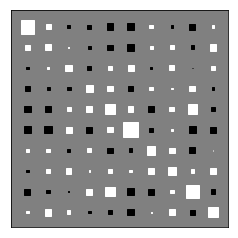

In [35]:
hinton(true_total_cov)

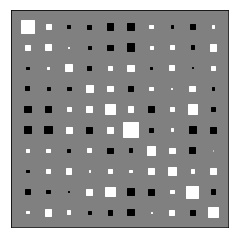

In [37]:
hinton(est_total_cov.detach().numpy())

In [40]:
from tracepredictive import *

trace_pred = TracePredictive(model, svi, num_samples=1000).run(data[:,:500], initial_hyperparameters)
random_idx = np.random.randint(1000)
predictive_dst_sample = [torch.unsqueeze(trace.nodes['obs']['value'][random_idx,:],dim=0) for trace in trace_pred.exec_traces]
predictive_dst_sample = torch.cat(predictive_dst_sample, dim=0)

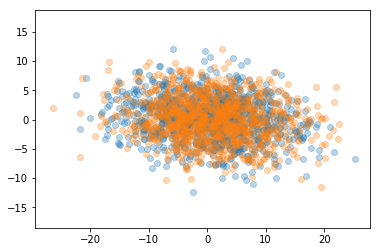

In [85]:
random_dims = np.random.choice(data.shape[1], size=2, replace=False)
random_dims.sort()
plt.scatter(*data.detach().numpy().T[random_dims,:1000],alpha=.3)
#plt.axis('equal');
#plt.figure()
plt.scatter(*predictive_dst_sample.detach().numpy().T[random_dims],alpha=.3);
plt.axis('equal');

In [ ]:
true_cov_factor.transpose(0,1)

In [ ]:
est_cov_factor

In [86]:
from pyro.infer.mcmc import MCMC, NUTS

In [ ]:
nuts_kernel = NUTS(conditioned_model)
posterior = MCMC(nuts_kernel,
                 num_samples=100,
                 warmup_steps=100,
                 num_chains=7).run(data, initial_hyperparameters)